In [ ]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob 
import keras
import IPython.display as ipd
import librosa

import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape, Bidirectional, Softmax, Attention

# bidir, softmax, attn

from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm

## TensorFlow
import tensorflow as tf
tf.test.is_gpu_available()

input_duration=3
# % pylab inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_prefix = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


### RAVDESS DATASET

In [ ]:
# Data Directory
# Please edit according to your directory change.
Ravdess_path = drive_prefix + "SYDE 522 - Team Project/Code/data/"
dir_list = os.listdir(Ravdess_path)
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'audio_speech_actors_01-24']


In [ ]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0

for i in dir_list:
    if i == "audio_speech_actors_01-24":
        continue
    file_list = os.listdir(Ravdess_path + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = Ravdess_path + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        source = "Ravdess"

        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"

        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1

        if nm[4] == '01':
            statement = 0
        else:
            statement = 1

        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1

        if emotion == 1:
            lb = "neutral"
        elif emotion == 2:
            lb = "calm"
        elif emotion == 3:
            lb = "happy"
        elif emotion == 4:
            lb = "sad"
        elif emotion == 5:
            lb = "angry"
        elif emotion == 6:
            lb = "fearful"
        elif emotion == 7:
            lb = "disgust"
        elif emotion == 8:
            lb = "surprised"
        else:
            lb = "none"

        ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
        count += 1

In [ ]:
ravdess_db.head()

,path,source,actor,gender,emotion,emotion_lb
0,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,1,neutral
1,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,1,neutral
2,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,1,neutral
3,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,2,calm
4,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,2,calm


In [ ]:
ravdess_db.to_csv(drive_prefix + "SYDE 522 - Team Project/Code/list.csv")

In [ ]:
ravdess_db['split'] =  np.where((ravdess_db.actor ==23) | (ravdess_db.actor ==24), 'Test', 
                                (np.where((ravdess_db.actor ==21) | (ravdess_db.actor ==22),'Val','Train')))

In [ ]:
ravdess_db['split'].value_counts()

Train    1200
Test      120
Val       120
Name: split, dtype: int64

In [ ]:
# ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'neutral'], inplace = True)
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'calm'], inplace = True)
# ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'

In [ ]:
ravdess_db.emotion_lb.value_counts()

angry        192
happy        192
fearful      192
disgust      192
sad          192
surprised    192
Name: emotion_lb, dtype: int64

In [ ]:
dataset_db = ravdess_db.copy()

In [ ]:
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [ ]:
dataset_db.index=range(len(dataset_db.index))

In [ ]:
dataset_db.to_csv(drive_prefix + "SYDE 522 - Team Project/Code/list2.csv")

In [ ]:
dataset_db.emotion_lb.value_counts()
dataset_db.sort_values(by=['path'], inplace=True)
dataset_db.head()

,path,source,actor,gender,emotion,emotion_lb,split
0,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,3,male_happy,Train
3,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,3,male_happy,Train
5,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,3,male_happy,Train
1,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,3,male_happy,Train
2,/content/gdrive/MyDrive/SYDE 522 - Team Projec...,Ravdess,1,male,3,male_happy,Train


In [ ]:
dataset_db.index = range(len(dataset_db.index))

In [ ]:
dataset_db.shape

(1152, 7)

In [ ]:
######## RUN THIS CELL FOR 2 CLASSES! :)
# 2 class: Positive & Negative

# Positive: Happy, Surprised
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(dataset_db)):
    # if dataset_db.emotion[i] == 2: # Calm
    #     lb = "_positive"
    if dataset_db.emotion[i] == 3: # Happy
        lb = "_positive"
    elif dataset_db.emotion[i] == 4: # Sad
        lb = "_negative"
    elif dataset_db.emotion[i] == 5: # Angry
        lb = "_negative"
    elif dataset_db.emotion[i] == 6: # Fearful
        lb = "_negative"
    elif dataset_db.emotion[i] == 7: # Disgust
        lb = "_negative"
    elif dataset_db.emotion[i] == 8: # Surprised
        lb = "_positive"
    else: # dropped calm, neutral
        lb = "_error"
        
    # Add gender to the label    
    label2_list.append(dataset_db.gender[i] + lb)
    
len(label2_list)

dataset_db['label'] = label2_list
dataset_db.head()
print (dataset_db.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_positive', 'female_positive'], dtype='object')


In [ ]:
n_mfccaudio_duration = 3
sampling_rate = 22050*2
# input_length = sampling_rate * audio_duration # NameError: name 'audio_duration' is not defined
input_length = sampling_rate * n_mfccaudio_duration
n_mfcc = 12

In [ ]:
data_sample= np.zeros(input_length)
MFCC = librosa.feature.mfcc(data_sample, sr=sampling_rate, n_mfcc=n_mfcc)

In [ ]:
MFCC.shape
# (coefficients, windows)(?) - for 1 ____

(12, 259)

In [ ]:
dataset_db.split.value_counts()

Train    960
Test      96
Val       96
Name: split, dtype: int64

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
signal, sample_rate = librosa.load(dataset_db.path[0], res_type='kaiser_fast',sr=sampling_rate)
signal,index = librosa.effects.trim(signal,top_db = 25)
signal = scipy.signal.wiener(signal)

if len(signal) > input_length:
    signal = signal[0:input_length]
elif  input_length > len(signal):
    max_offset = input_length - len(signal)  
    signal = np.pad(signal, (0, max_offset), "constant")

In [ ]:
signal = np.array(signal).reshape(-1,1)


In [ ]:
signal.shape

(132300, 1)

In [ ]:
# Cell w/ the loading bar, takes ~
audios= np.empty(shape=(dataset_db.shape[0],128, MFCC.shape[1], 1))

count=0
for i in tqdm(range(len(dataset_db))):
    signal, sample_rate = librosa.load(dataset_db.path[i], res_type='kaiser_fast',sr=sampling_rate)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)
    
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    logspec = librosa.amplitude_to_db(melspec)
    logspec = np.expand_dims(logspec, axis=-1)
    audios[count,] = logspec 
    count+=1

In [ ]:
audios.shape
# (, n_mels, , )

(1152, 128, 259, 1)

In [ ]:
import h5py
with h5py.File(drive_prefix + 'SYDE 522 - Team Project/Code/Ravdess_audio_Mel_spec.h5', 'w') as hf:
    hf.create_dataset("Ravdess_audio_Mel_spec",  data=audios)

In [ ]:
import h5py
with h5py.File(drive_prefix + 'SYDE 522 - Team Project/Code/Ravdess_audio_Mel_spec.h5', 'r') as hf:
  audios = hf['Ravdess_audio_Mel_spec'][:]

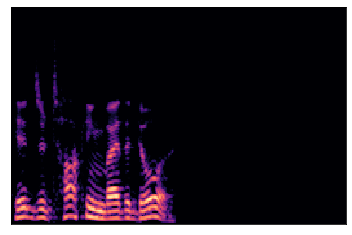

In [ ]:
librosa.display.specshow(audios[0].reshape(128,259))

In [ ]:
x_train = audios[(dataset_db['split'] == 'Train')]

#### use this for all 12 classes
# y_train = dataset_db.emotion_lb[(dataset_db['split'] == 'Train')]

#### use this for not all classes
y_train = dataset_db.label[(dataset_db['split'] == 'Train')]

print(x_train.shape,y_train.shape)

(960, 128, 259, 1) (960,)


In [ ]:
x_test = audios[(dataset_db['split'] == 'Val')]

#### use this for all 12 classes
# y_test = dataset_db.emotion_lb[(dataset_db['split'] == 'Val')]

#### use this for not all classes
y_test = dataset_db.label[(dataset_db['split'] == 'Val')]

print(x_test.shape,y_test.shape)

(96, 128, 259, 1) (96,)


In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn = x_train
x_testcnn = x_test

In [ ]:
x_traincnn.shape,x_testcnn.shape,y_train.shape,y_test.shape

((960, 128, 259, 1), (96, 128, 259, 1), (960, 4), (96, 4))

In [ ]:
# CNN I/P Config
num_classes = len(np.unique(np.argmax(y_train, 1)))
input_shape = x_traincnn.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9

#LSTM Configuration
num_lstm = 256


In [ ]:
input_shape

(128, 259, 1)

In [ ]:
# clear model to prevent layers appending constantly while troubleshooting
tf.keras.backend.clear_session()

model = Sequential(name='Audio_CNN_2D')

# LFLB1


model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2), strides=(4,4)))
model.add(Dropout(0.2))

# Input 0 of layer lstm_5 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 16, 32, 64)
# model.add(Bidirectional(LSTM(128))) # possible, but unsure how to implement
# model.add(Bidirectional(LSTM(64, input_shape=input_shape[0:-1])))
# model.add((LSTM(64, input_shape=input_shape[0:-1])))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(128, input_shape=input_shape[0:-1])))
# model.add(Dropout(0.2))

# model.add(Attention())
# model.add(Dropout(0.2))

model.add(Dense(64, activation="tanh"))
model.add(Dropout(0.2))

model.add(Softmax())
model.add(Dropout(0.2))

# model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('elu'))
# model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('elu'))
# model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
# model.add(Dropout(0.25))

In [ ]:
model.add(Flatten())
# # FC
model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.Adam(lr=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 259, 256)     6656      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 259, 256)     1024      
_________________________________________________________________
activation (Activation)      (None, 128, 259, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 259, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 129, 256)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 129, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 129, 64)      

## Temp location for saving results
# What was done:
model = Sequential(name='Audio_CNN_2D')

### LFLB1
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2,2), strides=(4,4)))
model.add(Dropout(0.2))

model.add(Dense(64, activation="tanh"))
model.add(Dropout(0.2))

model.add(Softmax())
model.add(Dropout(0.2))

model.add(Flatten())
### FC
model.add(Dense(units=num_classes, activation='softmax'))

### Model compilation
opt = optimizers.Adam(lr=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model summary:
Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 128, 259, 256)     6656      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 259, 256)     1024      
_________________________________________________________________
activation (Activation)      (None, 128, 259, 256)     0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 259, 256)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 129, 256)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 129, 256)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 129, 64)       409664    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 129, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 129, 64)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 129, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 32, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 16, 32, 64)        4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 32, 64)        0         
_________________________________________________________________
softmax (Softmax)            (None, 16, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                393228    
=================================================================
Total params: 814,988
Trainable params: 814,348
Non-trainable params: 640
_________________________________________________________________

# Accuracy:
50% accuracy

In [ ]:
# model.shape
# 

In [ ]:
#Train Config

batch_size = 16
num_epochs = 100

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint(drive_prefix + 'SYDE 522 - Team Project/Code/model/Audio_2DCNN_4L_R2.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Epoch 1/100
60/60 [==============================] - 42s 148ms/step - loss: 1.3421 - categorical_accuracy: 0.3510 - val_loss: 1.4884 - val_categorical_accuracy: 0.3333
Epoch 2/100
60/60 [==============================] - 8s 139ms/step - loss: 1.2260 - categorical_accuracy: 0.4519 - val_loss: 1.4599 - val_categorical_accuracy: 0.6250
Epoch 3/100
60/60 [==============================] - 8s 139ms/step - loss: 1.0236 - categorical_accuracy: 0.5933 - val_loss: 1.4506 - val_categorical_accuracy: 0.4375
Epoch 4/100
60/60 [==============================] - 8s 139ms/step - loss: 0.9054 - categorical_accuracy: 0.6454 - val_loss: 1.1312 - val_categorical_accuracy: 0.6146
Epoch 5/100
60/60 [==============================] - 8s 139ms/step - loss: 0.8460 - categorical_accuracy: 0.6341 - val_loss: 1.1631 - val_categorical_accuracy: 0.6458
Epoch 6/100
60/60 [==============================] - 8s 140ms/step - loss: 0.7915 - categorical_accuracy: 0.6855 - val_loss: 0.9938 - val_categorical_accuracy: 0.66

In [ ]:
max(cnnhistory.history['val_categorical_accuracy'])

0.7916666865348816

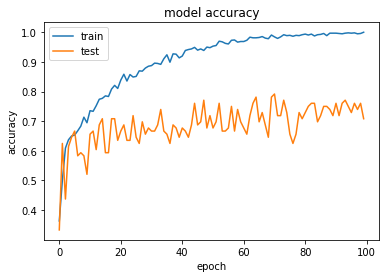

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

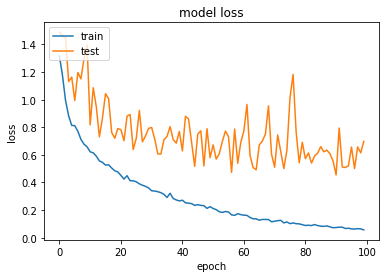

In [ ]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model.json

import json
model_json = model.to_json()
with open(drive_prefix + "SYDE 522 - Team Project/Code/model/Audio_2DCNN_4L_R2.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open(drive_prefix + 'SYDE 522 - Team Project/Code/model/Audio_2DCNN_4L_R2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
from keras.models import load_model

# Returns a compiled model identical to the previous one
loaded_model.load_weights(drive_prefix + 'SYDE 522 - Team Project/Code/model/Audio_2DCNN_4L_R2.h5')

In [ ]:
#new_model = load_model('/content/gdrive/MyDrive/BME 3A/SYDE 522/Audio_2DCNN_4L.h5')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
# prints out most accurate epoch

accuracy: 79.17%


In [ ]:
x_test_data = audios[(dataset_db['split'] == 'Test')]
y_test_data = dataset_db.label[(dataset_db['split'] == 'Test')]

print(x_test_data.shape,y_test_data.shape)

(96, 128, 259, 1) (96,)


In [ ]:
preds = loaded_model.predict(x_test_data,batch_size=16,verbose=1)
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

6/6 [==============================] - 0s 41ms/step


In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_negative
9,male_negative


In [ ]:
actualdf = pd.DataFrame({'actualvalues': y_test_data})
actualdf[:10]
actualdf.index = range(len(actualdf.index))

In [ ]:
finaldf = pd.concat([actualdf,preddf],axis=1)
finaldf.head()

,actualvalues,predictedvalues
0,male_positive,male_positive
1,male_positive,male_positive
2,male_positive,male_positive
3,male_positive,male_positive
4,male_positive,male_positive


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,6), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [ ]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

78.125

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

71.80382443540338

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[30,  2,  0,  0],
       [12,  4,  0,  0],
       [ 0,  0, 25,  7],
       [ 0,  0,  0, 16]])

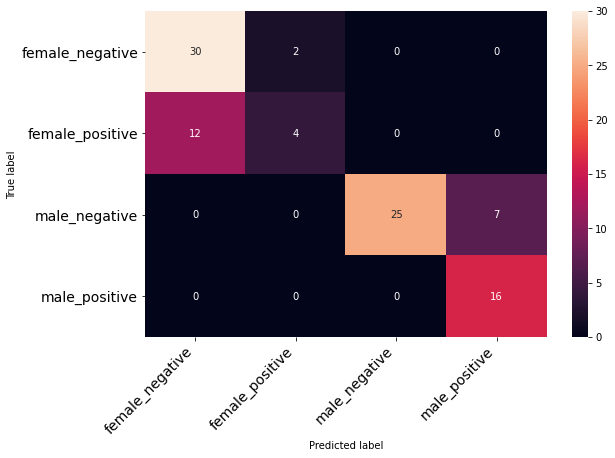

In [ ]:
class_names=sorted(set(finaldf.actualvalues))
print_confusion_matrix(c, class_names)
